In [242]:
import numpy as np
import matplotlib as cm
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D

In [247]:
data1 = np.random.multivariate_normal([0,0,0], 0.01*np.eye(3), 400)
data2 = np.random.multivariate_normal([0,0,1], 0.01*np.eye(3), 400)
data3 = np.random.multivariate_normal([0,1,0], 0.01*np.eye(3), 400)
data4 = np.random.multivariate_normal([1,0,0], 0.01*np.eye(3), 400)
data = np.concatenate((np.concatenate((np.concatenate((data1, data2)), data3)), data4))

In [248]:
#Data of shape (n,p)
class DirichletMixtureConjugate:
    #Data of shape (n,p) where p is the dimensionality of cluster, *arg refers to the four prior hyperparameters of the normal inverse wishart
    def __init__(self, data, alpha = 1,lamb = 0.1, K_ini = None, standardize = True, save = False, **kwargs):
        ## Integrate data
        if standardize:
            data = (data - np.mean(data, axis = 0))/(np.std(data, axis = 0))
        self.data = data
        (n,p) = data.shape
        if K_ini == None:
            K_ini = int(np.log(n)) + 1
        
        ## Normal-Inverse Wishart hyperparameters
        self.mu = kwargs.get("mu", np.zeros(p))
        self.lamb = lamb
        self.psi = kwargs.get("psi", 10*np.eye(p))
        self.nu = kwargs.get("nu", 100)
        self.alpha = alpha
        
        ## Initialize state of the Markov Chain, we take one cluster theta and labels
        self.nLabels = K_ini # Number of labels
        nPerCluster, nRemaining = n // K_ini, n % K_ini
        self.countLabels = [nPerCluster + 1 if i < nRemaining else nPerCluster for i in range(K_ini)] # number of elements in each label
        self.labels = np.array([i for i in range(K_ini) for j in range(self.countLabels[i])]) #for each observation, label, starting at 0
        self.parameters = [[np.zeros(p),np.eye(p)] for i in range(K_ini)]
        
        ## History fitting
        self.history = {"nbClusters" : [self.nLabels], "logLikelihood" : []}
        self.count = 0
        if save:
            self.count = 1
        self.plot()
    
    # Compute posterior probability
    def computeLogLikelihood(self):
        n = self.data.shape[0]
        score = 0
        for i in range(n):
            score += st.multivariate_normal.logpdf(self.data[i], self.parameters[self.labels[i]][0], self.parameters[self.labels[i]][1])
        return score
    
    # Update the attributes to perform posterior sampling
    def updatePosteriorParam(self, label):
        subData = self.data[self.labels == label,:]
        ## Parameters of the Posterior distribution
        yBar = np.mean(subData, axis = 0)
        n = subData.shape[0]
        S = sum(map(lambda x: np.outer(x,x), subData))
        self.lambPost = self.lamb + n
        self.nuPost = self.nu + n
        self.muPost = (self.lamb*self.mu + n*yBar)/(self.lambPost)
        self.psiPost = self.psi + S + self.lamb*(np.outer(self.mu,self.mu)) - self.lambPost*(np.outer(self.muPost,self.muPost))
        
    # Perform gibbs sampling on a whole round of labels and parameters
    def gibbsSampling(self):
        (n,p) = self.data.shape
        ## 2) Sample with regards to the labels:
        perm = np.random.permutation(n)
        for i in perm:
            ## Remove i from its cluster / Can be computationally improved by keeping a dictionaty up to date
            currLabel = self.labels[i]
            self.labels[i] = -1
            if self.countLabels[currLabel] == 1:
                self.labels[self.labels > currLabel] -= 1
                self.parameters.pop(currLabel)
                self.nLabels -= 1
                self.countLabels.pop(currLabel)
            else:
                self.countLabels[currLabel] -= 1
            
            ## Compute probabilities of the sampling
            preprobs = list(map(lambda y: y[0] * st.multivariate_normal.pdf(self.data[i], y[1][0], y[1][1]) , zip(self.countLabels,self.parameters)))
            preprobs.append(self.alpha * st.multivariate_normal.pdf(self.data[i], self.mu,  (((self.lamb + 1)*(self.nu))/((self.lamb)*(self.nu - p - 1)))*self.psi))
            probs = np.array(preprobs)
            ## Choose
            choice = np.random.multinomial(1,probs/(np.sum(probs)))
            chosenLabel = np.where(choice == 1)[0][0]
            
            ## If new label
            if chosenLabel == self.nLabels:
                ### Sample posterior parameters / Update attributes
                self.countLabels.append(1)
                self.labels[i] = self.nLabels
                self.nLabels += 1
                self.updatePosteriorParam(chosenLabel)
                psiStar = st.invwishart.rvs(self.nuPost, self.psiPost)
                muStar = np.random.multivariate_normal(self.muPost, (1/self.lambPost)*psiStar)
                self.parameters.append([muStar, psiStar])
            else:
                self.countLabels[chosenLabel] += 1
                self.labels[i] = chosenLabel
                
        ## 1) Sample with regards to the parameters
        for label in range(self.nLabels):
            self.updatePosteriorParam(label)
            psiStar = st.invwishart.rvs(self.nuPost, self.psiPost)
            muStar = np.random.multivariate_normal(self.muPost, (1/self.lambPost)*psiStar)
            self.parameters[label] = [muStar, psiStar]
            
    def fit(self, epoch = 100, vis = False):
        for i in range(epoch):
            self.gibbsSampling()
            self.history["nbClusters"].append(self.nLabels)
            self.history["logLikelihood"].append(self.computeLogLikelihood())
            if vis:
                self.plot()
            #time.sleep(1)
    
    ### Plot data when p <= 2
    def plot(self):
        if self.data.shape[1] == 2:
            def eigsorted(cov):
                vals, vecs = np.linalg.eigh(cov)
                order = vals.argsort()[::-1]
                return vals[order], vecs[:,order]
            x = self.data[:,0]
            y = self.data[:,1]
            nstd = 1
            ax = plt.subplot(111)
            for parameter in self.parameters:
                cov = parameter[1]
                vals, vecs = eigsorted(cov)
                theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
                w, h = 2 * nstd * np.sqrt(vals)
                ell = Ellipse(xy=(parameter[0][0], parameter[0][1]),
                              width=w, height=h,
                              angle=theta, color='black')
                ell.set_facecolor('none')
                ax.add_artist(ell)
            N = 10
            cmap = plt.cm.jet
            cmaplist = [cmap(i) for i in range(cmap.N)]
            cmap = cmap.from_list('Custom cmap', cmaplist)
            plt.scatter(self.data[:,0], self.data[:,1], c = np.array(self.labels), cmap = cmap)
            if self.count:
                plt.text(-0.17, -2.2, "T = " + str(self.count), fontsize=12)
                plt.savefig("epoch" + str(self.count) + ".png")
                self.count += 1
            plt.show()
        
        elif self.data.shape[1] == 3:
            fig = plt.figure()
            cmap = plt.cm.jet
            cmaplist = [cmap(i) for i in range(cmap.N)]
            cmap = cmap.from_list('Custom cmap', cmaplist)
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(self.data[:,0], self.data[:,1], self.data[:,2], c = np.array(self.labels), cmap = cmap)
            if self.count:
                plt.savefig("epoch3D" + str(self.count) + ".png")
                self.count += 1
            plt.show()
        else :
            print("Too many dimensions")

In [249]:
def stickBreaking(alpha, baseDistribution):
    val = [] ## Samples from baseditribution
    density = []
    currentVal = 1
    while currentVal > 10**(-12):
        sample = baseDistribution()
        val.append(sample)
        weight = np.random.beta(1, alpha)
        density.append(weight*currentVal)
        currentVal *= (1-weight)
    return (val,density)

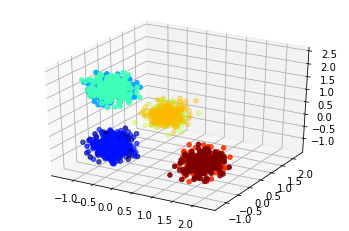

In [253]:
diri = DirichletMixtureConjugate(data, save = True)# K_ini = 10)

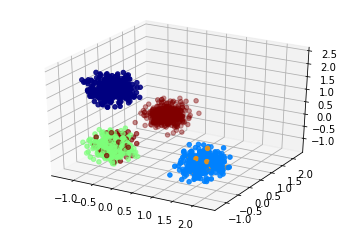

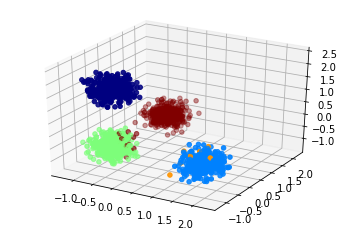

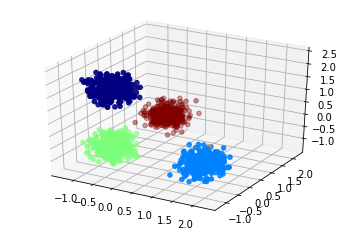

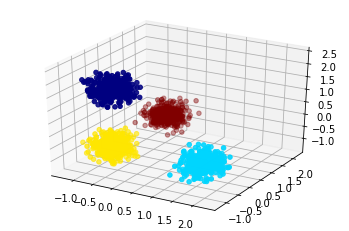

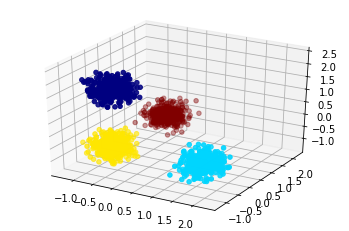

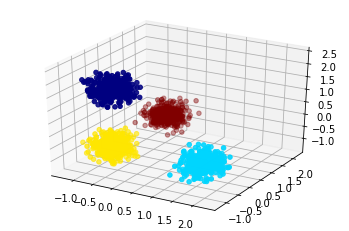

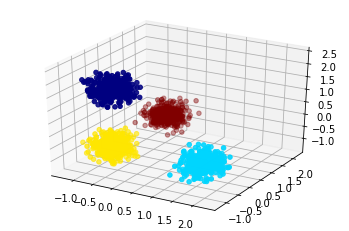

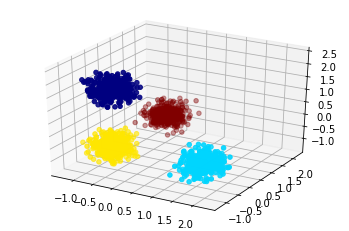

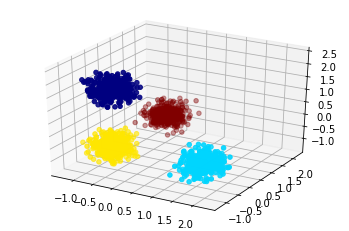

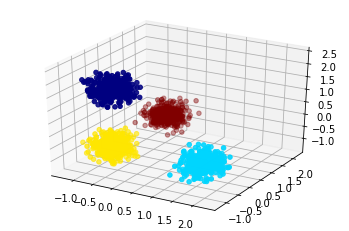

In [255]:
diri.fit(epoch = 10, vis = True)

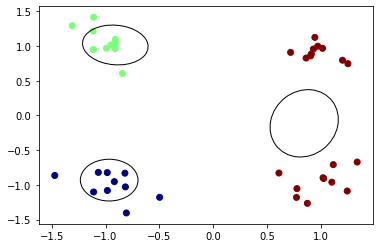

<Figure size 432x288 with 0 Axes>

In [76]:
diri.plot()
plt.savefig("epoch1.png")